# References

#### Examples
 - [Sample pipeline for text feature extraction and evaluation](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html)
 - [Column Transformer with Mixed Types](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py)
 - [A Deep Dive Into Sklearn Pipelines](https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines)
 - [Introducing the ColumnTransformer](https://jorisvandenbossche.github.io/blog/2018/05/28/scikit-learn-columntransformer/)
 - [Selecting dimensionality reduction with Pipeline and GridSearchCV](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html)
 - [Using XGBoost with sklearn](https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn)
 
#### Documentation
 - [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
 - [FeatureUnion](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)
 - [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
 - [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
 - [LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)
 - [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data

In [2]:
# food = pd.read_csv('../scrapdata/FoodBalanceSheets_E_All_Data.csv', encoding = 'latin1')

In [3]:
vit = pd.read_csv('../data/no-show-300k.csv')

# Transformations required for modeling
def transform_vitoria(df):
    new_names = ['age', 'gender', 'app_registration', 'app_date', 'week_day', 'show_up',
                 'diabetes', 'alcoholism', 'hypertension', 'handicap', 'smokes', 
                 'monetary_help', 'tuberculosis', 'sms_reminder', 'days_to_appointment']
    new_order = ['age', 'gender', 'week_day', 'days_to_appointment', 'diabetes', 'alcoholism', 
                 'hypertension', 'handicap', 'smokes', 'monetary_help', 'tuberculosis', 
                 'sms_reminder', 'show_up']
    df.columns = new_names
    df = df.loc[:, new_order]
    df.loc[:, 'week_day'] = df.loc[:, 'week_day'].str.lower()
    df.loc[:, 'gender'] = df.loc[:, 'gender'].str.lower()
    df.loc[:, 'days_to_appointment'] = df.loc[:, 'days_to_appointment'] * -1
    df = df.replace({'show_up': {'Show-Up': 1, 'No-Show': 0, '2': 0}})
    
    return df

vit = transform_vitoria(vit)
vit.head()

,age,gender,week_day,days_to_appointment,diabetes,alcoholism,hypertension,handicap,smokes,monetary_help,tuberculosis,sms_reminder,show_up
0,19,m,wednesday,29,0,0,0,0,0,0,0,0,1
1,24,f,wednesday,1,0,0,0,0,0,0,0,0,1
2,4,f,tuesday,1,0,0,0,0,0,0,0,0,1
3,5,m,thursday,15,0,0,0,0,0,0,0,1,1
4,38,m,tuesday,6,0,0,0,0,0,0,0,1,1


# Visualization

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5,1,'Sunday')

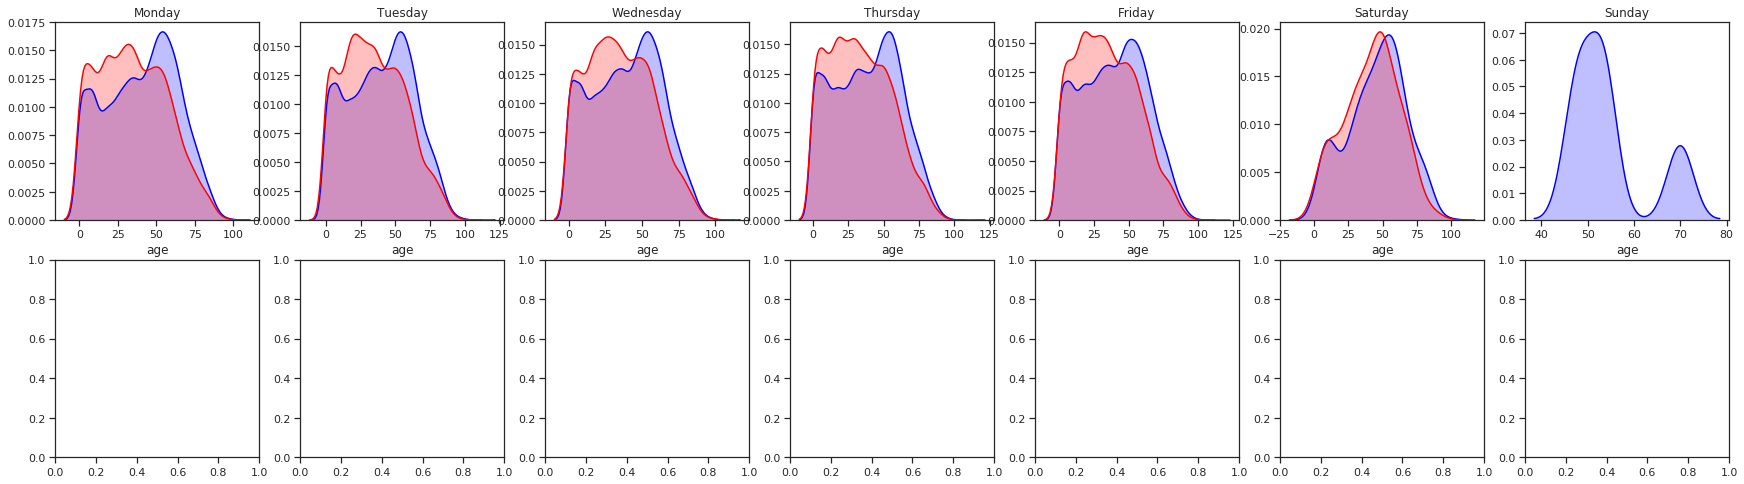

In [102]:
fig, ax = plt.subplots(2, 7, figsize=(30, 8))

sns.distplot(vit.loc[vit.show_up == 1].loc[vit.week_day == 'monday'].age, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[0,0])
sns.distplot(vit.loc[vit.show_up == 0].loc[vit.week_day == 'monday'].age, color='red', hist=False, kde_kws={'shade':True}, ax=ax[0,0])
ax[0,0].set_title('Monday')

sns.distplot(vit.loc[vit.show_up == 1].loc[vit.week_day == 'tuesday'].age, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[0,1])
sns.distplot(vit.loc[vit.show_up == 0].loc[vit.week_day == 'tuesday'].age, color='red', hist=False, kde_kws={'shade':True}, ax=ax[0,1])
ax[0,1].set_title('Tuesday')

sns.distplot(vit.loc[vit.show_up == 1].loc[vit.week_day == 'wednesday'].age, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[0,2])
sns.distplot(vit.loc[vit.show_up == 0].loc[vit.week_day == 'wednesday'].age, color='red', hist=False, kde_kws={'shade':True}, ax=ax[0,2])
ax[0,2].set_title('Wednesday')

sns.distplot(vit.loc[vit.show_up == 1].loc[vit.week_day == 'thursday'].age, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[0,3])
sns.distplot(vit.loc[vit.show_up == 0].loc[vit.week_day == 'thursday'].age, color='red', hist=False, kde_kws={'shade':True}, ax=ax[0,3])
ax[0,3].set_title('Thursday')

sns.distplot(vit.loc[vit.show_up == 1].loc[vit.week_day == 'friday'].age, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[0,4])
sns.distplot(vit.loc[vit.show_up == 0].loc[vit.week_day == 'friday'].age, color='red', hist=False, kde_kws={'shade':True}, ax=ax[0,4])
ax[0,4].set_title('Friday')

sns.distplot(vit.loc[vit.show_up == 1].loc[vit.week_day == 'saturday'].age, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[0,5])
sns.distplot(vit.loc[vit.show_up == 0].loc[vit.week_day == 'saturday'].age, color='red', hist=False, kde_kws={'shade':True}, ax=ax[0,5])
ax[0,5].set_title('Saturday')

sns.distplot(vit.loc[vit.show_up == 1].loc[vit.week_day == 'sunday'].age, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[0,6])
sns.distplot(vit.loc[vit.show_up == 0].loc[vit.week_day == 'sunday'].age, color='red', hist=False, kde_kws={'shade':True}, ax=ax[0,6])
ax[0,6].set_title('Sunday')

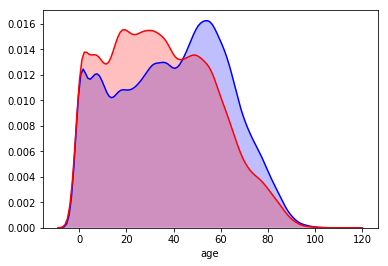

In [33]:
sns.distplot(vit[vit.show_up == 1].age, color='blue', hist=False, kde_kws={'shade':True})
sns.distplot(vit[vit.show_up == 0].age, color='red', hist=False, kde_kws={'shade':True})

([<matplotlib.axis.XTick object at 0x7f37dc8eab70>, <matplotlib.axis.XTick object at 0x7f37dc8ea4a8>, <matplotlib.axis.XTick object at 0x7f37dc8ea390>, <matplotlib.axis.XTick object at 0x7f37d2c9ce10>, <matplotlib.axis.XTick object at 0x7f37d2cc0278>, <matplotlib.axis.XTick object at 0x7f37d2cc0a90>, <matplotlib.axis.XTick object at 0x7f37d2cc0438>], <a list of 7 Text xticklabel objects>)


None

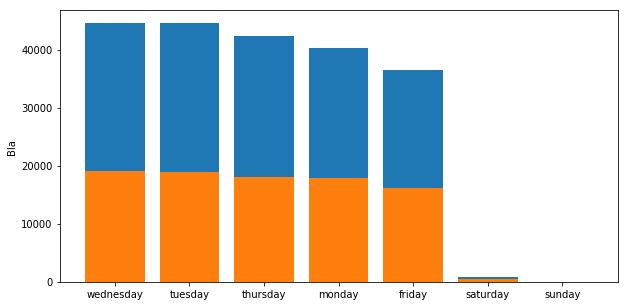

In [54]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(7), vit[vit.show_up == 1].week_day.value_counts(), width=0.8)
plt.bar(np.arange(7), vit[vit.show_up == 0].week_day.value_counts(), width=0.8)
ticks = plt.xticks(np.arange(7), vit.week_day.value_counts().index)
plt.ylabel('Bla')
display(print(ticks))

---

# Preprocessing

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


#pd.get_dummies(vit).head()
encoder = OneHotEncoder(sparse=False)

categorical_features = ['gender', 'week_day']
categorical_encoder = OneHotEncoder(sparse=False)
categorical_transformer = ColumnTransformer([('cat', categorical_encoder, categorical_features)], remainder='passthrough')

preprocess = Pipeline([('cat_transformer', categorical_transformer)])

X = vit.drop('show_up', axis=1)
y = vit.loc[:, 'show_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
from time import time

def print_grid(X_train, y_train, grid, model, parameters):
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in model.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best score: %0.3f" % grid.best_score_)
    print("Best parameters set:")
    best_parameters = grid.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    return grid

# AdaBoostClassifier

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
clf_adaboost = AdaBoostClassifier(decision_tree, random_state=42)

model_adaboost = Pipeline([
    ('cat_transformer', categorical_transformer),
    ('clf', clf_adaboost)
])

parameters_adaboost = {
    'clf__base_estimator__max_depth': [None, 5],
    'clf__n_estimators': [50],#, 100, 150],
    'clf__learning_rate': [0.5]#, 1]#, 1.5]
}

scorer = make_scorer(f1_score)

grid_adaboost = GridSearchCV(model_adaboost, parameters_adaboost, cv=5, n_jobs=-1, verbose=2, scoring=scorer)

In [31]:
print_grid(X_train, y_train, grid_adaboost, model_adaboost, parameters_adaboost)
#grid_adaboost.fit(X_train, y_train)

Performing grid search...
pipeline: ['cat_transformer', 'clf']
parameters:
{'clf__base_estimator__max_depth': [None, 5], 'clf__n_estimators': [50], 'clf__learning_rate': [0.5]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.3min finished


done in 297.176s

Best score: 0.820
Best parameters set:
	clf__base_estimator__max_depth: 5
	clf__learning_rate: 0.5
	clf__n_estimators: 50


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cat_transformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_...None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__base_estimator__max_depth': [None, 5], 'clf__n_estimators': [50], 'clf__learning_rate': [0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=2)

# XGBoostClassifier

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier

clf_xgboost = XGBClassifier(n_jobs=4, silent=False)

parameters_xgboost = {
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.1, 0.5]
}

scorer = make_scorer(f1_score)

model_xgboost = Pipeline([
    ('cat_transformer', categorical_transformer),
    ('clf', clf_xgboost)
])

def custom_f1_eval(y_pred, y_true):
    labels = y_true.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y_pred]
    return 'f1_score', f1_score(labels, y_bin)

fit_params = {
    'clf__eval_set': [(categorical_transformer.fit_transform(X_test), y_test)],
    'clf__eval_metric': custom_f1_eval,
    'clf__early_stopping_rounds': 10
}

grid_xgboost = GridSearchCV(model_xgboost, parameters_xgboost, cv=5, n_jobs=-1, verbose=2, scoring=scorer)

In [88]:
grid_xgboost.best_estimator_.named_steps.clf.feature_importances_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.03896104,
        0.        ,  0.        ,  0.        ,  0.        ,  0.2857143 ,
        0.35064936,  0.        ,  0.07792208,  0.        ,  0.        ,
        0.06493507,  0.01298701,  0.        ,  0.16883117], dtype=float32)

In [91]:
f1_score(y_test, grid_xgboost.predict(X_test))

0.8227815317966708

In [81]:
grid_xgboost.fit(X_train, y_train, **fit_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.4min finished


[21:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-error:0.30108	validation_0-f1_score:0.822782
Multiple eval metrics have been passed: 'validation_0-f1_score' will be used for early stopping.

Will train until validation_0-f1_score hasn't improved in 10 rounds.
[21:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-error:0.30108	validation_0-f1_score:0.822782
[21:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-error:0.30108	validation_0-f1_score:0.822782
[21:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	validation_0-error:0.30108	validation_0-f1_score:0.822782
[21:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	validation_0-error:0.

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cat_transformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__max_depth': [3, 5], 'clf__learning_rate': [0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=2)

In [79]:
model_xgboost.fit(X_train, y_train, **fit_params)#clf__eval_set=[(X_test, y_test)], clf__eval_metric=custom_f1_eval, clf__early_stopping_rounds=10)

[21:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-error:0.30108	validation_0-f1_score:0.822782
Multiple eval metrics have been passed: 'validation_0-f1_score' will be used for early stopping.

Will train until validation_0-f1_score hasn't improved in 10 rounds.
[21:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-error:0.30108	validation_0-f1_score:0.822782
[21:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-error:0.30108	validation_0-f1_score:0.822782
[21:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	validation_0-error:0.30108	validation_0-f1_score:0.822782
[21:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	validation_0-error:0.

Pipeline(memory=None,
     steps=[('cat_transformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1))])

In [73]:
model_xgboost.named_steps.clf.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 0,
 'subsample': 1}

In [14]:
a.best_estimator_.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [15]:
f1_score(y_test, a.best_estimator_.predict(X_test))

0.82010393113570557

In [7]:
import xgboost as xgb

In [ ]:
xgb.XGBClassifier()

In [31]:
from sklearn.model_selection import GridSearchCV


<bound method OneHotEncoder.get_feature_names of OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)>